## Forecasting Energy Output

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('../data/interim/filled_for_forecasting.csv', index_col = 0, parse_dates = True)

In [3]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts'],
      dtype='object')

In [4]:
df.index

DatetimeIndex(['2015-10-01 00:00:00', '2015-10-01 00:15:00',
               '2015-10-01 00:30:00', '2015-10-01 00:45:00',
               '2015-10-01 01:00:00', '2015-10-01 01:15:00',
               '2015-10-01 01:30:00', '2015-10-01 01:45:00',
               '2015-10-01 02:00:00', '2015-10-01 02:15:00',
               ...
               '2020-12-31 21:30:00', '2020-12-31 21:45:00',
               '2020-12-31 22:00:00', '2020-12-31 22:15:00',
               '2020-12-31 22:30:00', '2020-12-31 22:45:00',
               '2020-12-31 23:00:00', '2020-12-31 23:15:00',
               '2020-12-31 23:30:00', '2020-12-31 23:45:00'],
              dtype='datetime64[ns]', name='Site Time', length=184224, freq=None)

We're going to forecast energy output, so let's calcuate that on an hourly basis by summing the average power.  

In [5]:
energy_hourly = df[['Shark Meter, KWtotal Kilowatts']].resample('H').sum()*.25

In [53]:
energy_hourly.columns= ['Shark Meter, KWH']

In [54]:
decomp = seasonal_decompose(energy_hourly, period=24*365, model = 'add')

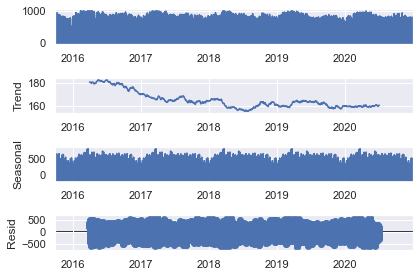

In [55]:
decomp.plot();

It's really hard to see the seasonality here because the data is so noisy, so let's try this again with a rolling average.  

In [56]:
energy_hourly_rolling_7D = energy_hourly.rolling(window='7D').mean()

In [57]:
decomp = seasonal_decompose(energy_hourly_rolling_7D, period=24*365, model = 'add')

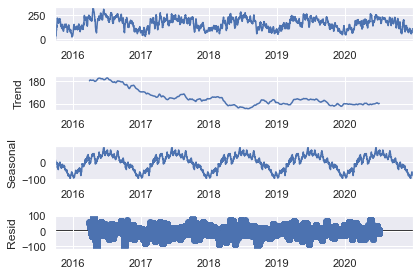

In [58]:
decomp.plot();

Now we clearly see the seasonality, the downward trend as the solar cells degrade.  We also see that the residuals are still quite large.  

In [59]:
# Let's use pre-2020 data as training data and 2020 data as test data
train = energy_hourly_rolling_7D.loc[:'2020-01-01']
test = energy_hourly_rolling_7D.loc['2020-01-01':]

### Holt-Winters Method

In [60]:
train.head()

,"Shark Meter, KWH"
Site Time,
2015-10-01 00:00:00,0.0
2015-10-01 01:00:00,0.0
2015-10-01 02:00:00,0.0
2015-10-01 03:00:00,0.0
2015-10-01 04:00:00,0.0


In [61]:
import warnings
warnings.filterwarnings("ignore")

In [62]:
HW_model = ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=24*365).fit()

In [63]:
start=len(train)
end=len(train)+len(test)-1
HW_preds = HW_model.predict(start=start, end=end).rename('HW Predictions')

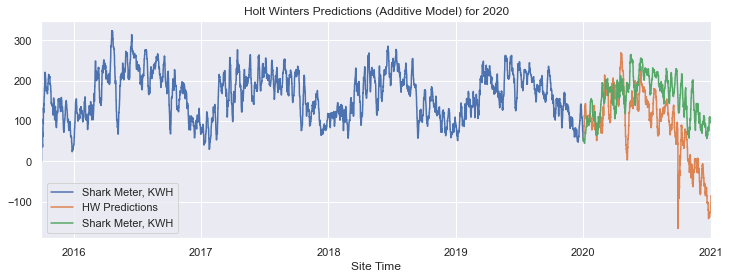

In [64]:
ax = train.plot(figsize=(12,4),legend=True)
HW_preds.plot(ax=ax, legend=True)
test.plot(ax=ax, legend=True);
plt.title('Holt Winters Predictions (Additive Model) for 2020');

The H-W Method does not perform well. It illustrates a sharp downward trend and it's not clear why. 

In [65]:
mae = mean_absolute_error(test, HW_preds)
print(f'MAE Error: {mae:11.10}')
rmse = np.sqrt(mean_squared_error(test, HW_preds))
print(f'RMSE Error: {rmse:11.10}')

MAE Error: 79.96045672
RMSE Error: 97.95438754


I'm curious to see if we can forecast 15-min power data given it's so noisy.  Let's see by taking a month's worth of data.

In [66]:
train_15min = df['Shark Meter, KWtotal Kilowatts'].loc['2020-09-01':'2020-10-01']
test_15min = df['Shark Meter, KWtotal Kilowatts'].loc['2020-10-01':'2020-10-08']

In [67]:
HW_model_15min = ExponentialSmoothing(train_15min, trend='add',seasonal='add',seasonal_periods=4*24).fit()

In [68]:
start=len(train_15min)
end=len(train_15min)+len(test_15min)-1
HW_preds_15min = HW_model_15min.predict(start=start, end=end).rename('HW Predictions for 15min Power Data')

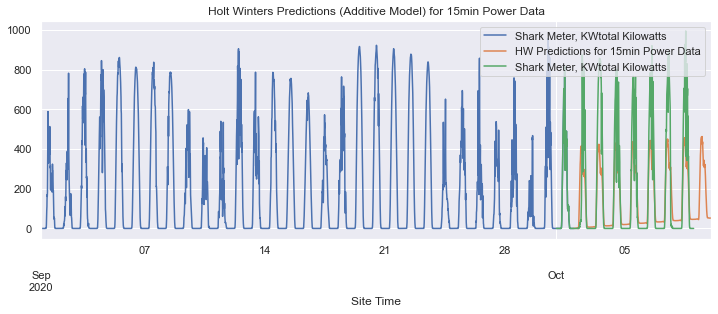

In [69]:
ax = train_15min.plot(figsize=(12,4),legend=True)
HW_preds_15min.plot(legend=True)
test_15min.plot(ax=ax, legend=True);
plt.title('Holt Winters Predictions (Additive Model) for 15min Power Data');

It also does not perform well here. We can see that it is under-forecasting power output, and it also has a strange upward trend of the nightly data.   

In [70]:
mae = mean_absolute_error(test_15min, HW_preds_15min)
print(f'MAE Error: {mae:11.10}')
rmse = np.sqrt(mean_squared_error(test_15min, HW_preds_15min))
print(f'RMSE Error: {rmse:11.10}')

MAE Error: 103.4070128
RMSE Error: 168.3513979


### SARIMA

I'm finding that autoarima is not returning if I have more than a few hundred data points.  It's just taking too long to compute.  So we have to really think about that we're trying to forecast.  If I'm trying to forecast degradation of the panels, it makes sense to really smooth out the data and forecast that over many many years.  If I'm trying to forecast just 15-minute data it makes more sense to just take a week or so of data and forecast based on that.  If I"m trying to forecast over a year, do something in between.  

Let's start with trying to forecast 15-minute data. We'll run autoarima with just two days of data and see what it says in terms of our model.  

In [23]:
small_15min = df['Shark Meter, KWtotal Kilowatts'].loc['2020-09-01':'2020-09-02']

In [24]:
small_15min.shape

(192,)

In [25]:
#Get best parameters from auto_arima

stepwise_fit = auto_arima(small_15min, 
                            m=96,
                            seasonal=True,
                            trace=True,
                            maxiter = 10,
                            error_action='ignore',   # we don't want to know if an order does not work
                            suppress_warnings=False,  # we don't want convergence warnings
                            stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[96] intercept   : AIC=2157.842, Time=7.11 sec
 ARIMA(0,0,0)(0,0,0)[96] intercept   : AIC=2494.793, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[96] intercept   : AIC=2163.541, Time=2.90 sec
 ARIMA(0,0,1)(0,0,1)[96] intercept   : AIC=2374.319, Time=2.34 sec
 ARIMA(0,0,0)(0,0,0)[96]             : AIC=2569.061, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[96] intercept   : AIC=2155.680, Time=3.73 sec
 ARIMA(2,0,2)(0,0,0)[96] intercept   : AIC=2153.910, Time=0.08 sec
 ARIMA(2,0,2)(1,0,0)[96] intercept   : AIC=2156.287, Time=4.04 sec
 ARIMA(1,0,2)(0,0,0)[96] intercept   : AIC=2156.438, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[96] intercept   : AIC=2172.624, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[96] intercept   : AIC=2144.539, Time=0.11 sec
 ARIMA(3,0,2)(1,0,0)[96] intercept   : AIC=2147.197, Time=5.46 sec
 ARIMA(3,0,2)(0,0,1)[96] intercept   : AIC=2146.439, Time=4.77 sec
 ARIMA(3,0,2)(1,0,1)[96] intercept   : AIC=2148.414, Time=5.81 sec
 ARIMA(3,0,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  192
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -1063.724
Date:                Mon, 08 Feb 2021   AIC                           2141.449
Time:                        16:19:22   BIC                           2164.251
Sample:                             0   HQIC                          2150.684
                                - 192                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.7271     13.510      0.646      0.518     -17.752      35.206
ar.L1          0.7073      0.036     19.827      0.000       0.637       0.777
ar.L2          0.0803      0.045      1.777      0.075      -0.008       0.169
ar.L3          0.3743      0.040      9.291      0.000       0.295       0.453
ar.L4         -0.1363      0.050     -2.714      0.007      -0.235      -0.038
ar.L5         -0.1071      0.053     -2.036      0.042      -0.210      -0.004
sigma2      3839.3921    242.063     15.861      0.000    3364.957    4313.828
===================================================================================
Ljung-Box (Q):                       15.36   Jarque-Bera (JB):               202.78
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.33
Prob(H) (two-sided):                  0.16   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ok, so now let's train our model with two weeks of data and see if it looks better than H-W.  

In [26]:
sarimax_model_15min = SARIMAX(train_15min,order=(5,0,0),seasonal_order=(0,0,0,96))
results = sarimax_model_15min.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:     Shark Meter, KWtotal Kilowatts   No. Observations:                 2976
Model:                           SARIMAX(5, 0, 0)   Log Likelihood              -16556.627
Date:                            Mon, 08 Feb 2021   AIC                          33125.253
Time:                                    16:19:22   BIC                          33161.243
Sample:                                09-01-2020   HQIC                         33138.204
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9054      0.008    113.063      0.000       0.890       0.921
ar.L2          0.0392      0.009      4.270      0.000       0.021       0.057
ar.L3          0.0569      0.009      6.045      0.000       0.038       0.075
ar.L4          0.1117      0.010     11.041      0.000       0.092       0.131
ar.L5         -0.1342      0.008    -16.478      0.000      -0.150      -0.118
sigma2      3981.6706     40.664     97.916      0.000    3901.970    4061.371
===================================================================================
Ljung-Box (Q):                      237.39   Jarque-Bera (JB):             37496.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
start=len(train_15min)
end=len(train_15min)+len(test_15min)-1
sarimax_preds_15min = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(5,0,0)(0,0,0,96) Predictions')

In [28]:
mae = mean_absolute_error(test_15min, sarimax_preds_15min)
mse = mean_squared_error(test_15min, sarimax_preds_15min)
rmse = np.sqrt(mse)
print('MAE: {}'.format(mae))
print('MSE: {}'.format(mse))
print('RMSE: {}'.format(rmse))

MAE: 194.14610546875
MSE: 117651.04986102476
RMSE: 343.00298812258876


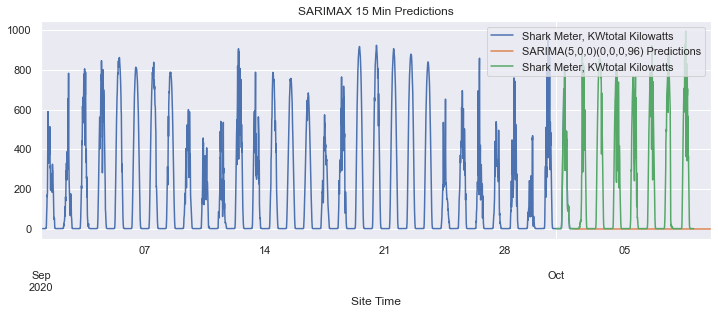

In [29]:
# Plot predictions against known values
ax = train_15min.plot(legend=True,figsize=(12,4),title='SARIMAX 15 Min Predictions')
sarimax_preds_15min.plot(legend=True)
test_15min.plot(ax=ax, legend=True);

We can see that the SARIMA model is not capturing the cycles of the data at all.  It's predicting a flatline of zero.

Let's try with the hourly rolling data which is smoothed out.  

In [71]:
small_hourly = energy_hourly['Shark Meter, KWH'].loc['2020-06-01':'2020-06-10']

In [72]:
#Get best parameters from auto_arima

stepwise_fit = auto_arima(small_hourly, 
                            m=24,
                            seasonal=True,
                            trace=True,
                            maxiter = 10,
                            error_action='ignore',   # we don't want to know if an order does not work
                            suppress_warnings=False,  # we don't want convergence warnings
                            stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=2793.289, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3385.317, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=2829.857, Time=0.64 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=3183.046, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=3505.109, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=2793.776, Time=0.45 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=2790.317, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=2844.419, Time=0.09 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=2953.577, Time=1.65 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=2791.414, Time=1.71 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=2798.964, Time=0.41 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=2788.442, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=2823.384, Time=0.08 sec
 ARIMA(2,0,1)(2,0,0)[24] intercept   : AIC=2824.024, Time=1.94 sec
 ARIMA(2,0,1)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  240
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 24)   Log Likelihood               -1387.860
Date:                              Mon, 08 Feb 2021   AIC                           2785.720
Time:                                      16:31:30   BIC                           2803.123
Sample:                                           0   HQIC                          2792.732
                                              - 240                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     27.9992     15.630      1.791      0.073      -2.634      58.632
ar.L1          1.3085      0.062     21.205      0.000       1.188       1.429
ar.L2         -0.4575      0.056     -8.103      0.000      -0.568      -0.347
ma.S.L24       0.5484      0.051     10.843      0.000       0.449       0.648
sigma2      6770.2530    574.132     11.792      0.000    5644.976    7895.530
===================================================================================
Ljung-Box (Q):                       81.14   Jarque-Bera (JB):                77.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
train_hourly = energy_hourly.loc['2020-06-01':'2020-09-30']
test_hourly = energy_hourly.loc['2020-10-01':'2020-10-31']

In [74]:
sarimax_model_hourly = SARIMAX(train_hourly,order=(2,0,0),seasonal_order=(0,0,1,24))
results = sarimax_model_hourly.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Shark Meter, KWH   No. Observations:                 2928
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 24)   Log Likelihood              -17194.719
Date:                              Mon, 08 Feb 2021   AIC                          34397.437
Time:                                      16:31:44   BIC                          34421.365
Sample:                                  06-01-2020   HQIC                         34406.055
                                       - 09-30-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3112      0.012    112.081      0.000       1.288       1.334
ar.L2         -0.3954      0.012    -34.252      0.000      -0.418      -0.373
ma.S.L24       0.2499      0.013     19.974      0.000       0.225       0.274
sigma2      7374.4698    121.153     60.869      0.000    7137.014    7611.926
===================================================================================
Ljung-Box (Q):                      935.92   Jarque-Bera (JB):              2148.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
start=len(train_hourly)
end=len(train_hourly)+len(test_hourly)-1
sarimax_preds_hourly = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,0,0)(0,0,1,24) Predictions')

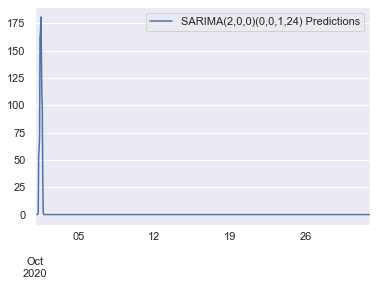

In [76]:
# Plot predictions against known values
#ax = train_hourly.plot(legend=True,figsize=(12,4),title='SARIMAX Hourly Predictions')
sarimax_preds_hourly.plot(legend=True);
#test_hourly.plot(ax=ax, legend=True);

We can see that it is also not able to capture the cyclical nature of the data.

Let's try predicting a longer-term trend with monthly values.  

In [77]:
# Let's try with monthly data
energy_monthly = energy_hourly_rolling_7D.resample('M').mean()

In [78]:
energy_monthly.shape

(63, 1)

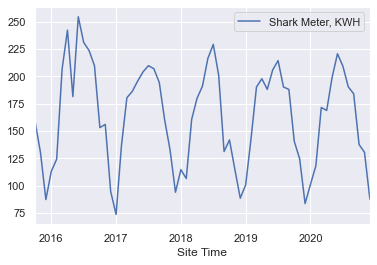

In [90]:
energy_monthly.plot();

In [80]:
#Get best parameters from auto_arima

stepwise_fit = auto_arima(energy_monthly, 
                            m=12,
                            seasonal=True,
                            trace=True,
                            maxiter = 10,
                      #      error_action='ignore',   # we don't want to know if an order does not work
                            suppress_warnings=False,  # we don't want convergence warnings
                            stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3749.418, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=664.829, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=602.339, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=625.478, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=827.780, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=618.861, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=602.440, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=609.010, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=854.956, Time=0.13 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=664.564, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=605.678, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=605.064, Time=0.08 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=636.909, Time=0.05 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -297.170
Date:                            Mon, 08 Feb 2021   AIC                            602.339
Time:                                    16:32:03   BIC                            610.912
Sample:                                         0   HQIC                           605.711
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.7620     17.865      2.226      0.026       4.748      74.776
ar.L1          0.4209      0.203      2.075      0.038       0.023       0.818
ar.S.L12       0.5889      0.157      3.749      0.000       0.281       0.897
sigma2       988.7257    277.226      3.566      0.000     445.372    1532.080
===================================================================================
Ljung-Box (Q):                       81.66   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.00   Prob(JB):                         0.89
Heteroskedasticity (H):               0.33   Skew:                             0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
train_monthly = energy_monthly.loc['2016':'2019']
test_monthly = energy_monthly.loc['2020':]

In [92]:
sarimax_model_monthly = SARIMAX(train_monthly,order=(1,0,0),seasonal_order=(0,0,1,12))
results = sarimax_model_monthly.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Shark Meter, KWH   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -236.701
Date:                              Mon, 08 Feb 2021   AIC                            479.403
Time:                                      16:37:07   BIC                            485.016
Sample:                                  01-31-2016   HQIC                           481.524
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9628      0.036     26.405      0.000       0.891       1.034
ma.S.L12       0.3450      0.208      1.661      0.097      -0.062       0.752
sigma2      1022.7691    218.950      4.671      0.000     593.636    1451.903
===================================================================================
Ljung-Box (Q):                       62.67   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.01   Prob(JB):                         0.88
Heteroskedasticity (H):               0.49   Skew:                             0.17
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

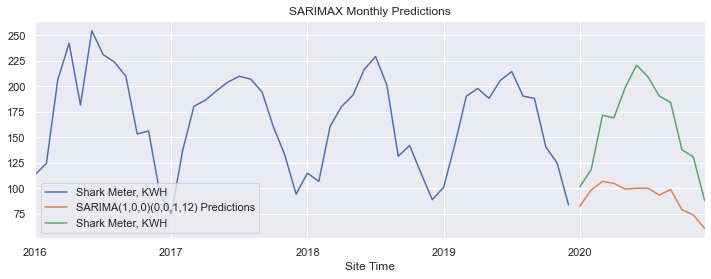

In [94]:
start=len(train_monthly)
end=len(train_monthly)+len(test_monthly)-1
sarimax_preds_monthly = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(0,0,1,12) Predictions')

# Plot predictions against known values
ax = train_monthly.plot(legend=True,figsize=(12,4),title='SARIMAX Monthly Predictions')
sarimax_preds_monthly.plot(legend=True);
test_monthly.plot(ax=ax, legend=True);